In [1]:
import functools
import localreg
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.gam import generalized_additive_model
from statsmodels.gam import smooth_basis
from statsmodels.nonparametric import kernel_regression
from statsmodels.tools import tools


np.set_printoptions(suppress=True)

In [2]:
def f_sin(x):
    return np.sin(x * np.pi)

def f_poly(x):
    x3 = x * x * x
    return 2 * x + x3 - 6 * x * x3

def f_inv(x):
    return 1. / (1. + 25 * x * x)

In [3]:
np.random.seed(2020)
x = np.sort(np.random.uniform(-1, 1, size=[100]))
epsilon = np.random.normal(size=[100])

In [4]:
def evaluate(estimator, true_model, min_x=-1., max_x=1.):
    x = np.linspace(min_x, max_x, 200)
    actual = estimator(x)
    return np.mean(np.square(actual - true_model(x)))

In [5]:
def kernel_estimator(f, epsilon, x):
    mse = np.inf
    best_model = None
    for h in np.linspace(0.01, 1, 100):
        kernel_model = kernel_regression.KernelReg(f(x) + epsilon, x, var_type='c', reg_type='lc', bw=[h])
        new_mse = evaluate(lambda x: kernel_model.fit(x)[0], f)
        if new_mse < mse:
            mse = new_mse
            best_model = kernel_model
    return best_model
kernel_model = kernel_estimator(f_sin, epsilon, x)
kernel_model.bw

array([0.14])

In [6]:
def loess_estimator(f, epsilon, x):
    def estimator(h, x0):        
        return localreg.localreg(
            x, f(x) + epsilon, x0, degree=2, kernel=localreg.gaussian, width=h)
    mse = np.inf
    best_model = None
    for h in np.linspace(0.01, 1, 100):
        loess_model = functools.partial(estimator, h)
        new_mse = evaluate(loess_model, f)
        if new_mse < mse:
            mse = new_mse
            best_model = loess_model
    return best_model
loess_model = loess_estimator(f_sin, epsilon, x)
loess_model.args

(0.29000000000000004,)

In [7]:
def spline_estimator(f, epsilon, x):
    mse = np.inf
    best_model = None
    for df in range(4, 50):
        smoother = smooth_basis.BSplines(x, df=[df], degree=[3])
        gam_model = generalized_additive_model.GLMGam(
            f(x) + epsilon, tools.add_constant(x), smoother=smoother).fit()
        new_mse = evaluate(
            lambda x: gam_model.predict(tools.add_constant(x), x.reshape([-1, 1]), transform=True),
            f,
            min_x=-min(x),
            max_x=max(x))
        if new_mse < mse:
            mse = new_mse
            best_model = gam_model
    return best_model
spline_model = spline_estimator(f_inv, epsilon, x)
spline_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                         GLMGam   Df Residuals:                       96
Model Family:                Gaussian   Df Model:                         3.00
Link Function:               identity   Scale:                          1.0982
Method:                         PIRLS   Log-Likelihood:                -144.54
Date:                Mon, 11 May 2020   Deviance:                       105.43
Time:                        15:44:06   Pearson chi2:                     105.
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1262      0.175      0.722      0.470      -0.216       0.468
x1             0.2405      0.272      0.883      0.377      -0.293       0.774
x0_s0          1.0340      1.054      0.981      0.327      -1.032       3.100
x0_s1         -0.0712      0.805     -0.088      0.929      -1.648       1.506
x0_s2         -0.1120      0.340     -0.330      0.742      -0.778       0.554
==============================================================================
"""

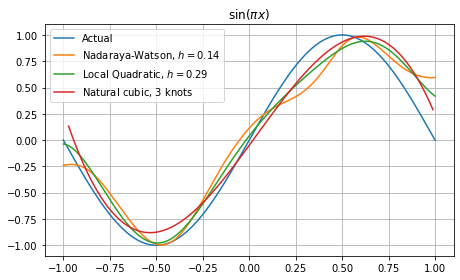

In [8]:
fig = plt.figure(figsize=(6.5, 4))
ax = fig.gca()
def plot_models(ax, f, kernel_model, loess_model, spline_model):
    x = np.linspace(-1, 1, 200)    
    ax.plot(x, f(x), label='Actual')
    ax.plot(x, kernel_model.fit(x)[0],
            label='Nadaraya-Watson, $h = {}$'.format(str(kernel_model.bw[0])[:4]))
    ax.plot(x, loess_model(x), label='Local Quadratic, $h = {}$'.format(str(loess_model.args[0])[:4]))
    x = np.linspace(
        min(spline_model.model.smoother.x), max(spline_model.model.smoother.x), 200)
    ax.plot(x, spline_model.predict(tools.add_constant(x), x.reshape([-1, 1]), transform=True),
           label='Natural cubic, ${}$ knots'.format(len(spline_model.params) - 2))
    ax.legend()
    ax.grid(True)
plot_models(
    ax, f_sin,
    kernel_estimator(f_sin, epsilon, x),
    loess_estimator(f_sin, epsilon, x),
    spline_estimator(f_sin, epsilon, x))
ax.set_title('$\sin(\pi x)$')
fig.tight_layout()
fig.savefig('regression_sin.pdf')

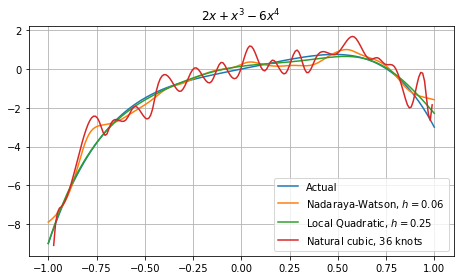

In [9]:
fig = plt.figure(figsize=(6.5, 4))
ax = fig.gca()
plot_models(
    ax, f_poly,
    kernel_estimator(f_poly, epsilon, x),
    loess_estimator(f_poly, epsilon, x),
    spline_estimator(f_poly, epsilon, x))
ax.set_title('$2x + x^3 - 6x^4$')
fig.tight_layout()
fig.savefig('regression_poly.pdf')

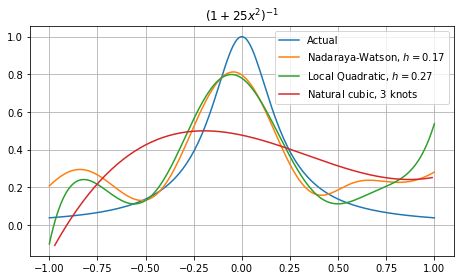

In [10]:
fig = plt.figure(figsize=(6.5, 4))
ax = fig.gca()
plot_models(
    ax, f_inv,
    kernel_estimator(f_inv, epsilon, x),
    loess_estimator(f_inv, epsilon, x),
    spline_estimator(f_inv, epsilon, x))
ax.set_title('$(1 + 25x^2)^{-1}$')
fig.tight_layout()
fig.savefig('regression_inv.pdf')